## 국민건강영양조사 데이터 이용 비만 사전 예측 및 비만 유발 요인 분석 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Matplotlib 한글 폰트 설정
# plt.rc('font', family='NanumMyeongjoOTF') # For MacOS
# print(plt.rcParams['font.family'])

plt.rc('font', family='NanumMyeongjo') # For Windows
print(plt.rcParams['font.family'])

['NanumMyeongjo']


### 분석방법
- 국민건강영양조사 및 청소년 건강행태 조사에 참여한 청소년 대상으로 분석 수행
- 기존에 발표된 청소년 비만 관련 논문을 바탕으로 Feature Selection
>> - "sex": 조사 대상자의 성별을 나타냅니다. 일반적으로 '1'은 남성을, '2'는 여성을 의미합니다.
>> - "age": 조사 대상자의 나이입니다. 보통 연령을 나타내는 정수로 표현됩니다.
>> - "D_1_1": 주관적 건강인지, 1. 매우 좋음, 2. 좋음, 3. 보통, 4. 나쁨, 5. 매우 나쁨, 9. 모름, 무응답
>> - "BP1": 평소 스트레스 인지 정도, 1. 대단히 많이 느낀다, 2. 많이 느끼는 편이다, 3. 조금 느끼는 편이다, 4. 거의 느끼지 않는다, 8. 비해당(소아), 9. 모름, 무응답
>> - "BO1": (만6세이상)주관적 체형인식, 1. 매우 마른 편, 2. 약간 마른 편, 3. 보통, 4. 약간 비만, 5. 매우 비만, 8. 비해당(만6세 미만), 9. 모름, 무응답
>> - "BE5_1": 1주일간 근력운동 일수, 1. 전혀 하지 않음, 2. 1일, 3. 2일, 4. 3일, 5. 4일, 6. 5일이상, 8. 비해당(소아), 9. 모름, 무응답
>> - "BE8_1", 평소 하루 앉아서 보내는 시간(시간), □□시간, 88. 비해당(소아), 99. 모름, 무응답
>> - "BP5": 2주이상 연속 우울감 여부
>> - "HE_ht": 조사 대상자의 신장(키)을 나타냅니다. 단위는 일반적으로 센티미터(cm)입니다.
>> - "HE_wt": 조사 대상자의 체중을 나타냅니다. 단위는 일반적으로 킬로그램(kg)입니다.
- EDA (탐색적 분석) : 다중 공선성, 데이터 시각화를 통한 Feature의 Value 분포, 통계량 등 확인
- Intermediate Report 연구 결과를 바탕으로 각 데이터별로 모델의 최고 성능을 보여준 결측치 처리 방법, 스케일링 여부, K = 5/10인 K-fold 교차 검증 수행
- 4가지 분류기법(Random Forest, Logistic Regression, SVM, MLP)사용
- 추가적으로 오버샘플링, PCA, K-Means 기법을 이용하여 모델의 Performance 변화를 확인 => 모델 별 그리드 서치 수행하며 청소년 통합/남자/여자 데이터 각각에 대해 모델 수립.

In [3]:
data_file = 'hn21_all.csv'
health_DT = pd.read_csv(data_file, index_col='ID')
health_DT.head(5)

/tmp/ipykernel_15782/541494103.py:2: DtypeWarning: Columns (140,380,513,660,671) have mixed types. Specify dtype option on import or set low_memory=False.
  health_DT = pd.read_csv(data_file, index_col='ID')


,mod_d,ID_fam,year,region,town_t,apt_t,psu,sex,age,age_month,...,LF_S10,LF_S11,LF_S12,LF_S13,LF_S14,LF_S14_1,LF_S15,LF_S16,LF_SECUR,LF_SECUR_G
ID,,,,,,,,,,,,,,,,,,,,,
A901215301,2023.01.13.,A9012153,2021.0,1.0,1.0,2.0,A901,1.0,61.0,NaN,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,1.0
A901215302,2023.01.13.,A9012153,2021.0,1.0,1.0,2.0,A901,1.0,57.0,NaN,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,1.0
A901225501,2023.01.13.,A9012255,2021.0,1.0,1.0,2.0,A901,2.0,39.0,NaN,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,1.0
A901225502,2023.01.13.,A9012255,2021.0,1.0,1.0,2.0,A901,2.0,19.0,NaN,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0,1.0
A901227201,2023.01.13.,A9012272,2021.0,1.0,1.0,2.0,A901,1.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 분석대상 컬럼 추출
# "sex": 조사 대상자의 성별을 나타냅니다. 일반적으로 '1'은 남성을, '2'는 여성을 의미합니다.
# "age": 조사 대상자의 나이입니다. 보통 연령을 나타내는 정수로 표현됩니다.
# "D_1_1": 주관적 건강인지, 1. 매우 좋음, 2. 좋음, 3. 보통, 4. 나쁨, 5. 매우 나쁨, 9. 모름, 무응답
# "BP1": 평소 스트레스 인지 정도, 1. 대단히 많이 느낀다, 2. 많이 느끼는 편이다, 3. 조금 느끼는 편이다, 4. 거의 느끼지 않는다, 8. 비해당(소아), 9. 모름, 무응답
# "BO1": (만6세이상)주관적 체형인식, 1. 매우 마른 편, 2. 약간 마른 편, 3. 보통, 4. 약간 비만, 5. 매우 비만, 8. 비해당(만6세 미만), 9. 모름, 무응답
# "BE5_1": 1주일간 근력운동 일수, 1. 전혀 하지 않음, 2. 1일, 3. 2일, 4. 3일, 5. 4일, 6. 5일이상, 8. 비해당(소아), 9. 모름, 무응답
# "BE8_1", 평소 하루 앉아서 보내는 시간(시간), □□시간, 88. 비해당(소아), 99. 모름, 무응답
# "BP5": 2주이상 연속 우울감 여부
# "HE_ht": 조사 대상자의 신장(키)을 나타냅니다. 단위는 일반적으로 센티미터(cm)입니다.
# "HE_wt": 조사 대상자의 체중을 나타냅니다. 단위는 일반적으로 킬로그램(kg)입니다.
health_DT_att = health_DT[["sex","age","D_1_1","BP1","BO1","BE5_1","BE8_1","BE8_2","BP5","HE_ht","HE_wt"]]

###  EDA (탐색적 분석) 히스토그램 추출

In [5]:
#
health_DT_att.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7090 entries, A901215301 to R904353004
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     7090 non-null   float64
 1   age     7090 non-null   float64
 2   D_1_1   6728 non-null   float64
 3   BP1     6728 non-null   float64
 4   BO1     6728 non-null   float64
 5   BE5_1   6728 non-null   float64
 6   BE8_1   6728 non-null   float64
 7   BE8_2   6728 non-null   float64
 8   BP5     6728 non-null   float64
 9   HE_ht   6615 non-null   float64
 10  HE_wt   6686 non-null   float64
dtypes: float64(11)
memory usage: 664.7+ KB


In [6]:
# 분석대상 컬럼의 이름 확인
health_DT_att.columns

Index(['sex', 'age', 'D_1_1', 'BP1', 'BO1', 'BE5_1', 'BE8_1', 'BE8_2', 'BP5',
       'HE_ht', 'HE_wt'],
      dtype='object')

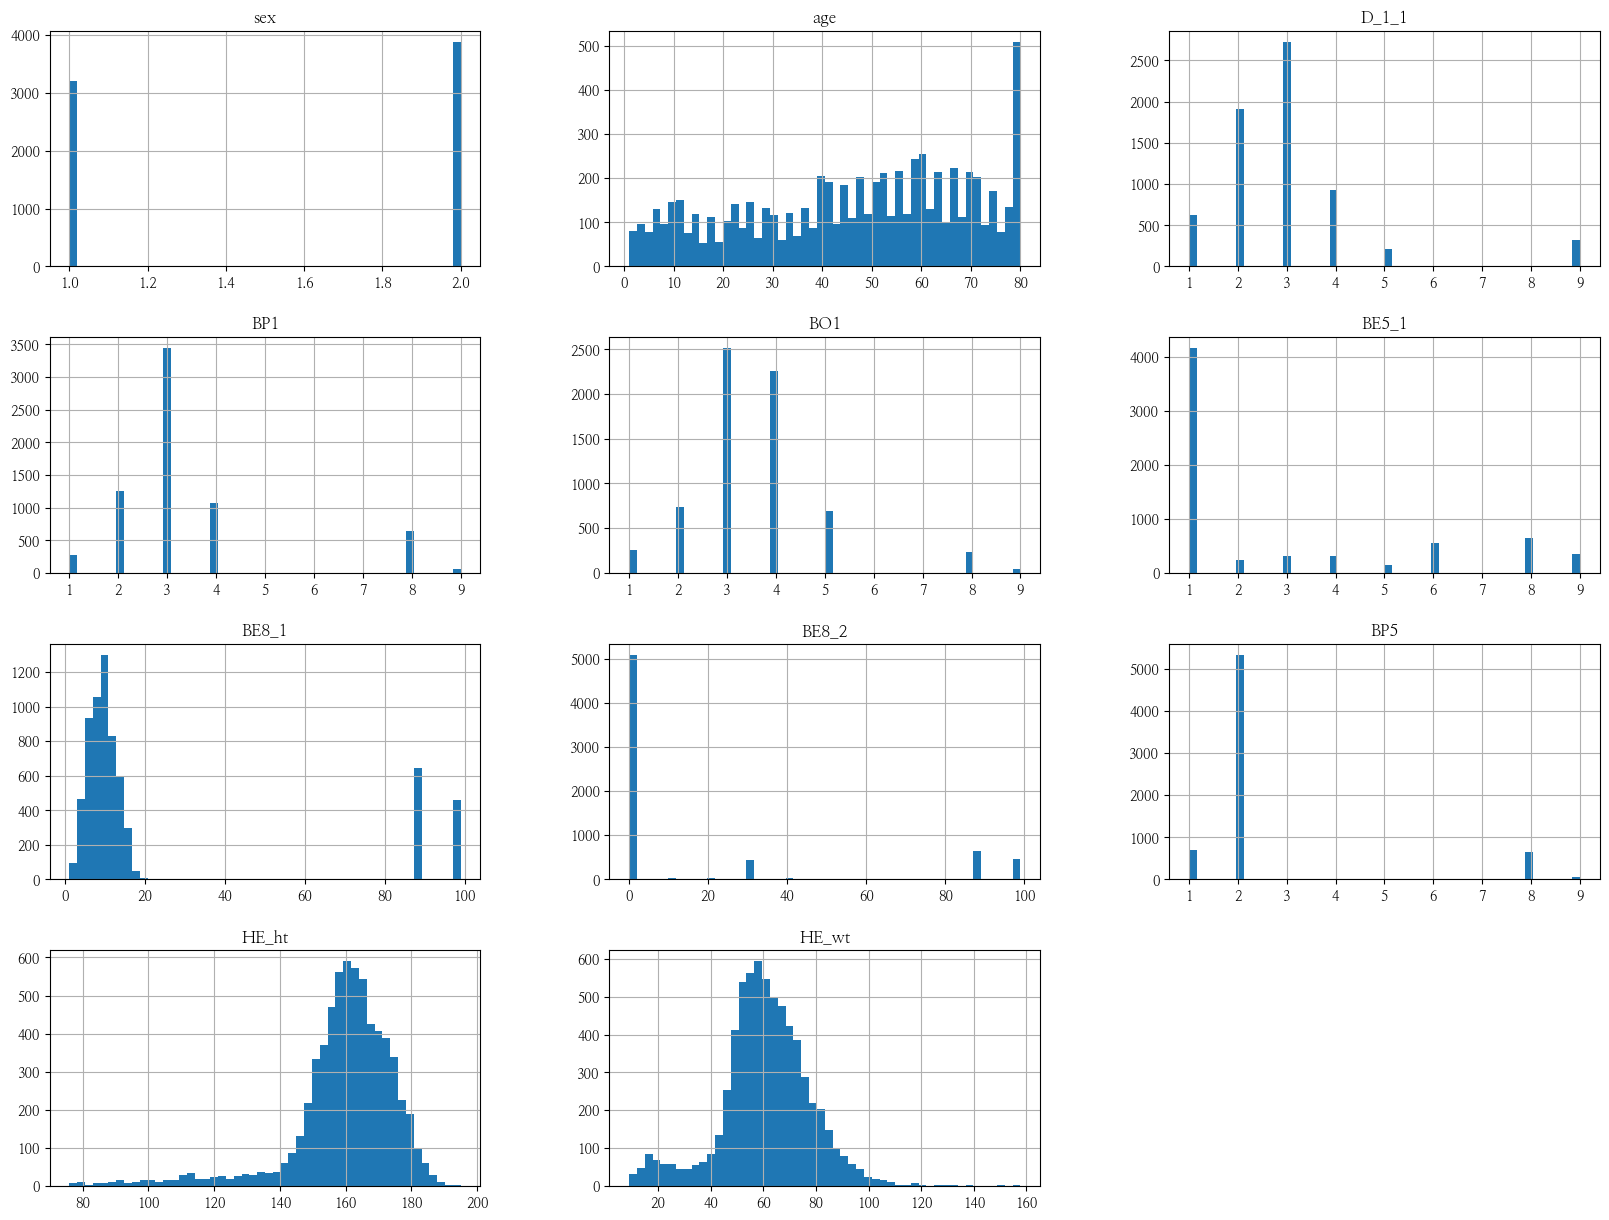

In [7]:
# 히스토그램
health_DT_att.hist(bins=50, figsize=(20,15))
plt.show()

### 체질량지수(BMI)
- "HE_ht"와 "HE_wt": 신장과 체중 데이터를 사용하여 체질량지수(BMI)를 계산하고, 이를 기반으로 비만 여부를 판단할 수 있습니다. 
- BMI는 체중(kg)을 신장(m)의 제곱으로 나눈 값으로 계산됩니다. WHO 기준에 따라 BMI 값을 기준으로 정상체중, 과체중, 비만 등으로 분류할 수 있습니다.

In [8]:
# BMI [BMI] (명목) 변수 생성
health_DT_att['BMI'] = (health_DT_att['HE_wt'] / (health_DT_att['HE_ht'] / 100)**2)
health_DT_att.loc[health_DT_att['BMI'] < 25, 'BMI'] = 0
health_DT_att.loc[health_DT_att['BMI'] >= 25, 'BMI'] = 1
print(health_DT_att['BMI'].value_counts())
print("==========================")
print(health_DT_att['BMI'])

BMI
0.0    4464
1.0    2150
Name: count, dtype: int64
ID
A901215301    1.0
A901215302    1.0
A901225501    0.0
A901225502    0.0
A901227201    0.0
             ... 
R904351302    1.0
R904353001    1.0
R904353002    0.0
R904353003    0.0
R904353004    0.0
Name: BMI, Length: 7090, dtype: float64


/tmp/ipykernel_15782/3681556703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  health_DT_att['BMI'] = (health_DT_att['HE_wt'] / (health_DT_att['HE_ht'] / 100)**2)


In [9]:
# 몸부게와 키 컬럼 삭제
health_DT_att = health_DT_att.drop(['HE_wt','HE_ht'], axis=1)

In [10]:
# 하루 평균 앉아서 보내는 시간(분 단위) 변수 생성
health_DT_att["SitTime"] = health_DT_att["BE8_1"]*60 + health_DT_att['BE8_2']

In [11]:
# 하루 평균 앉아서 보내는 시간 컬럼 삭제
health_DT_att = health_DT_att.drop(['BE8_1','BE8_2'], axis=1)

/home/arkwith/miniconda3/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/home/arkwith/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


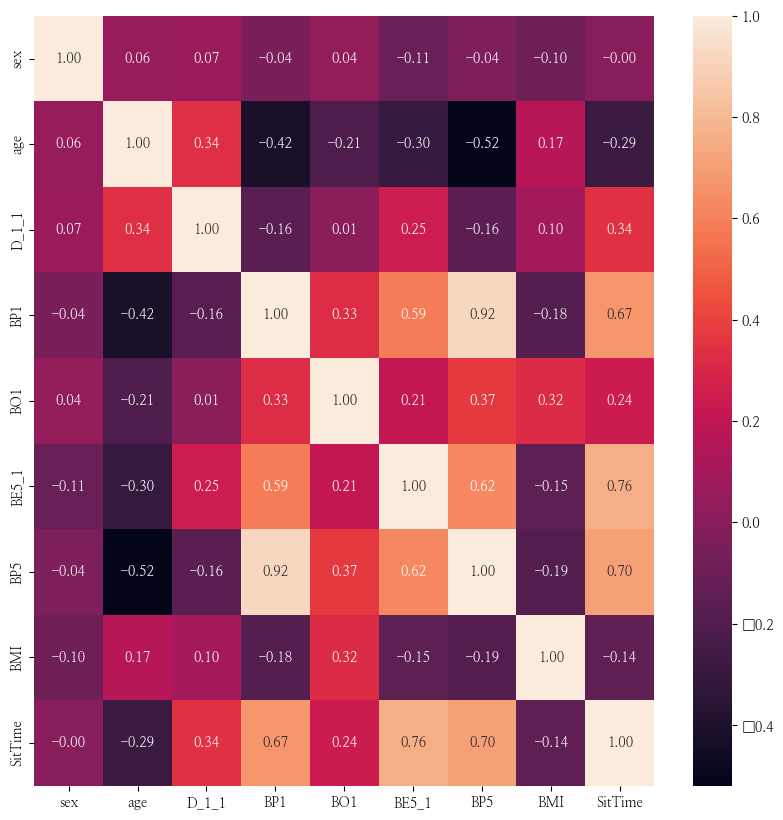

In [12]:
# 상관관계 분석
corr_matrix = health_DT_att.corr()
corr_matrix["BMI"].sort_values(ascending=False)

# 상관관계 히트맵
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

#### 상관관계 분석 결과
- BMI는 나이, 체형인식, 스트레스 인지 정도, 우울감 여부, 근력운동 일수, 하루 평균 앉아서 보내는 시간과 관련이 있음

### 종속변수 float -> 카테고리(순서X) 명목형

In [13]:
# BMI 종속변수 float -> 카테고리(순서X) 명목형으로 변환
health_DT_att['BMI'] = health_DT_att['BMI'].astype('category')
health_DT_att.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7090 entries, A901215301 to R904353004
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   sex      7090 non-null   float64 
 1   age      7090 non-null   float64 
 2   D_1_1    6728 non-null   float64 
 3   BP1      6728 non-null   float64 
 4   BO1      6728 non-null   float64 
 5   BE5_1    6728 non-null   float64 
 6   BP5      6728 non-null   float64 
 7   BMI      6614 non-null   category
 8   SitTime  6728 non-null   float64 
dtypes: category(1), float64(8)
memory usage: 505.6+ KB


### 독립변수 float -> 카테고리화 (순서)

In [14]:
# 주관적 건강상태 [D_1_1]] (순서)
from pandas.api.types import CategoricalDtype
print(health_DT_att['D_1_1'].value_counts())
print("==========================")
health_DT_att.loc[health_DT_att['D_1_1'] == 9, 'D_1_1'] = np.nan
health_DT_att['D_1_1'] = health_DT_att['D_1_1'].astype(CategoricalDtype(ordered=True))
print(health_DT_att['D_1_1'].value_counts())
print("==========================")
print(health_DT_att['D_1_1'])

D_1_1
3.0    2723
2.0    1910
4.0     931
1.0     623
9.0     327
5.0     214
Name: count, dtype: int64
D_1_1
3.0    2723
2.0    1910
4.0     931
1.0     623
5.0     214
Name: count, dtype: int64
ID
A901215301    3.0
A901215302    2.0
A901225501    4.0
A901225502    2.0
A901227201    2.0
             ... 
R904351302    4.0
R904353001    3.0
R904353002    2.0
R904353003    1.0
R904353004    1.0
Name: D_1_1, Length: 7090, dtype: category
Categories (5, float64): [1.0 < 2.0 < 3.0 < 4.0 < 5.0]


In [15]:
# 주관적 체형 인지 [BO1] (순서)
from pandas.api.types import CategoricalDtype
print(health_DT_att['BO1'].value_counts())
print("==========================")
health_DT_att.loc[health_DT_att['BO1'] == 8, 'BO1'] = np.nan
health_DT_att.loc[health_DT_att['BO1'] == 9, 'BO1'] = np.nan
health_DT_att['BO1'] = health_DT_att['BO1'].astype(CategoricalDtype(ordered=True))
print(health_DT_att['BO1'].value_counts())
print("==========================")
print(health_DT_att['BO1'])


BO1
3.0    2509
4.0    2257
2.0     734
5.0     691
1.0     256
8.0     233
9.0      48
Name: count, dtype: int64
BO1
3.0    2509
4.0    2257
2.0     734
5.0     691
1.0     256
Name: count, dtype: int64
ID
A901215301    4.0
A901215302    3.0
A901225501    4.0
A901225502    4.0
A901227201    2.0
             ... 
R904351302    4.0
R904353001    5.0
R904353002    3.0
R904353003    3.0
R904353004    3.0
Name: BO1, Length: 7090, dtype: category
Categories (5, float64): [1.0 < 2.0 < 3.0 < 4.0 < 5.0]


#### 설문조사 데이터 8, 9 (무응답,모름) -> NA 처리

In [16]:
# 1주일간 근력운동 일수 (등간)
from pandas.api.types import CategoricalDtype
print(health_DT_att['BE5_1'].value_counts())
print("==========================")
health_DT_att.loc[health_DT_att['BE5_1'] == 8, 'BE5_1'] = np.nan
health_DT_att.loc[health_DT_att['BE5_1'] == 9, 'BE5_1'] = np.nan
health_DT_att['BE5_1'] = health_DT_att['BE5_1'].astype(CategoricalDtype(ordered=True))
print(health_DT_att['BE5_1'].value_counts())
print("==========================")
print(health_DT_att['BE5_1'])


BE5_1
1.0    4156
8.0     646
6.0     551
9.0     357
4.0     318
3.0     312
2.0     236
5.0     152
Name: count, dtype: int64
BE5_1
1.0    4156
6.0     551
4.0     318
3.0     312
2.0     236
5.0     152
Name: count, dtype: int64
ID
A901215301    1.0
A901215302    6.0
A901225501    1.0
A901225502    5.0
A901227201    1.0
             ... 
R904351302    6.0
R904353001    4.0
R904353002    1.0
R904353003    NaN
R904353004    NaN
Name: BE5_1, Length: 7090, dtype: category
Categories (6, float64): [1.0 < 2.0 < 3.0 < 4.0 < 5.0 < 6.0]


In [17]:
# 결측치 확인 및 처리
print(health_DT_att.isnull().sum())
print("==========================")
health_DT_att.dropna(inplace=True)
print(health_DT_att.isnull().sum())
print("==========================")
print(health_DT_att.info())


sex           0
age           0
D_1_1       689
BP1         362
BO1         643
BE5_1      1365
BP5         362
BMI         476
SitTime     362
dtype: int64
sex        0
age        0
D_1_1      0
BP1        0
BO1        0
BE5_1      0
BP5        0
BMI        0
SitTime    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 5637 entries, A901215301 to R904353002
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   sex      5637 non-null   float64 
 1   age      5637 non-null   float64 
 2   D_1_1    5637 non-null   category
 3   BP1      5637 non-null   float64 
 4   BO1      5637 non-null   category
 5   BE5_1    5637 non-null   category
 6   BP5      5637 non-null   float64 
 7   BMI      5637 non-null   category
 8   SitTime  5637 non-null   float64 
dtypes: category(4), float64(5)
memory usage: 287.0+ KB
None


In [22]:
# 분류 기법을 이용한 비만 사전 예측 및 비만 유발 요인 파악
# - NB 이용
# - Decision Trees 이용
# - Random Forest 이용
# - XG Boost 이용
# - 모형간 비교 및 평가

# 데이터 분할
from sklearn.model_selection import train_test_split
X = health_DT_att.drop('BMI', axis=1)
y = health_DT_att['BMI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

num_attribs = list(X)
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs)
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)



In [23]:
# NB 이용
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nb_clf = GaussianNB()
nb_clf.fit(X_train_prepared, y_train)
nb_pred = nb_clf.predict(X_test_prepared)

print("Accuracy: ", accuracy_score(y_test, nb_pred))
print("Precision: ", precision_score(y_test, nb_pred))
print("Recall: ", recall_score(y_test, nb_pred))
print("F1 Score: ", f1_score(y_test, nb_pred))



Accuracy:  0.8049645390070922
Precision:  0.700218818380744
Recall:  0.794044665012407
F1 Score:  0.7441860465116279


[[ 0.08658187 -0.0519894  -0.07215067  0.01653151 -0.4301399   0.03551615
   0.00254919  0.01457277]
 [-0.15726427  0.09443171  0.13105194 -0.03002726  0.78129096 -0.06451029
  -0.00463026 -0.02646946]]


/home/arkwith/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


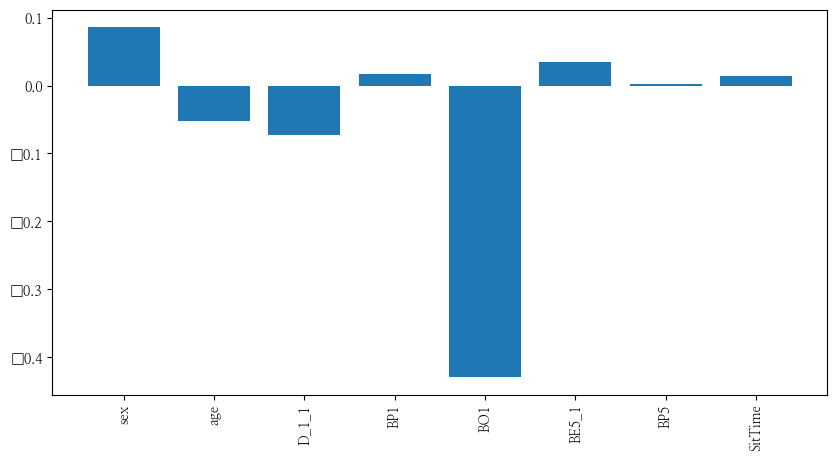

In [36]:
# 각 특성의 중요도 확인
feature_importances = nb_clf.theta_
print(feature_importances)

# 중요도 시각화
plt.figure(figsize=(10,5))
plt.bar(num_attribs, feature_importances[0])
plt.xticks(rotation=90)
plt.show()


In [24]:
# Decision Trees 이용
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_prepared, y_train)
dt_pred = dt_clf.predict(X_test_prepared)

print("Accuracy: ", accuracy_score(y_test, dt_pred))
print("Precision: ", precision_score(y_test, dt_pred))
print("Recall: ", recall_score(y_test, dt_pred))
print("F1 Score: ", f1_score(y_test, dt_pred))

Accuracy:  0.7579787234042553
Precision:  0.6585365853658537
Recall:  0.6699751861042184
F1 Score:  0.6642066420664207


In [34]:
# 각 특성의 중요도
for name, score in zip(X.columns, dt_clf.feature_importances_):
    print(name, score)


sex 0.05002743878462094
age 0.1926115366994525
D_1_1 0.07716801579911099
BP1 0.05905554241797738
BO1 0.3915949887040436
BE5_1 0.04249097977191721
BP5 0.020221439158321097
SitTime 0.16683005866455639


In [25]:
# Random Forest 이용
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_prepared, y_train)
rf_pred = rf_clf.predict(X_test_prepared)

print("Accuracy: ", accuracy_score(y_test, rf_pred))
print("Precision: ", precision_score(y_test, rf_pred))
print("Recall: ", recall_score(y_test, rf_pred))
print("F1 Score: ", f1_score(y_test, rf_pred))

Accuracy:  0.7907801418439716
Precision:  0.7226666666666667
Recall:  0.6724565756823822
F1 Score:  0.6966580976863754


In [33]:
# 각 특성의 중요도
feature_importances = rf_clf.feature_importances_
print(feature_importances)

# 중요도 순으로 정렬
attributes = num_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[0.03964292 0.25035452 0.05270163 0.04790595 0.38765433 0.03615057
 0.01350637 0.17208372]


[(0.38765432966376334, 'BO1'),
 (0.2503545152194029, 'age'),
 (0.17208371769514424, 'SitTime'),
 (0.0527016279925866, 'D_1_1'),
 (0.04790595201168514, 'BP1'),
 (0.039642918946269826, 'sex'),
 (0.03615056895020526, 'BE5_1'),
 (0.013506369520942725, 'BP5')]

In [27]:
# XG Boost 이용
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_prepared, y_train)
xgb_pred = xgb_clf.predict(X_test_prepared)

print("Accuracy: ", accuracy_score(y_test, xgb_pred))
print("Precision: ", precision_score(y_test, xgb_pred))
print("Recall: ", recall_score(y_test, xgb_pred))
print("F1 Score: ", f1_score(y_test, xgb_pred))

Accuracy:  0.8031914893617021
Precision:  0.7387862796833773
Recall:  0.6947890818858561
F1 Score:  0.7161125319693094


In [31]:
# the feature importance for each feature
print(xgb_clf.feature_importances_)
print(num_attribs)


[0.09446818 0.03437179 0.02824769 0.02683301 0.7312093  0.0290616
 0.02768159 0.02812684]
['sex', 'age', 'D_1_1', 'BP1', 'BO1', 'BE5_1', 'BP5', 'SitTime']


In [28]:
# 모형간 비교 및 평가
from sklearn.model_selection import cross_val_score

models = [nb_clf, dt_clf, rf_clf, xgb_clf]
model_names = ['Naive Bayes', 'Decision Trees', 'Random Forest', 'XG Boost']
accuracy = []
precision = []
recall = []
f1 = []

for model in models:
    accuracy.append(cross_val_score(model, X_train_prepared, y_train, cv=10, scoring='accuracy').mean())
    precision.append(cross_val_score(model, X_train_prepared, y_train, cv=10, scoring='precision').mean())
    recall.append(cross_val_score(model, X_train_prepared, y_train, cv=10, scoring='recall').mean())
    f1.append(cross_val_score(model, X_train_prepared, y_train, cv=10, scoring='f1').mean())

model_eval = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1})
model_eval


,Model,Accuracy,Precision,Recall,F1
0,Naive Bayes,0.788871,0.674941,0.783909,0.724879
1,Decision Trees,0.735202,0.626612,0.629655,0.627522
2,Random Forest,0.793536,0.721457,0.682139,0.700567
3,XG Boost,0.793534,0.721581,0.682741,0.701039


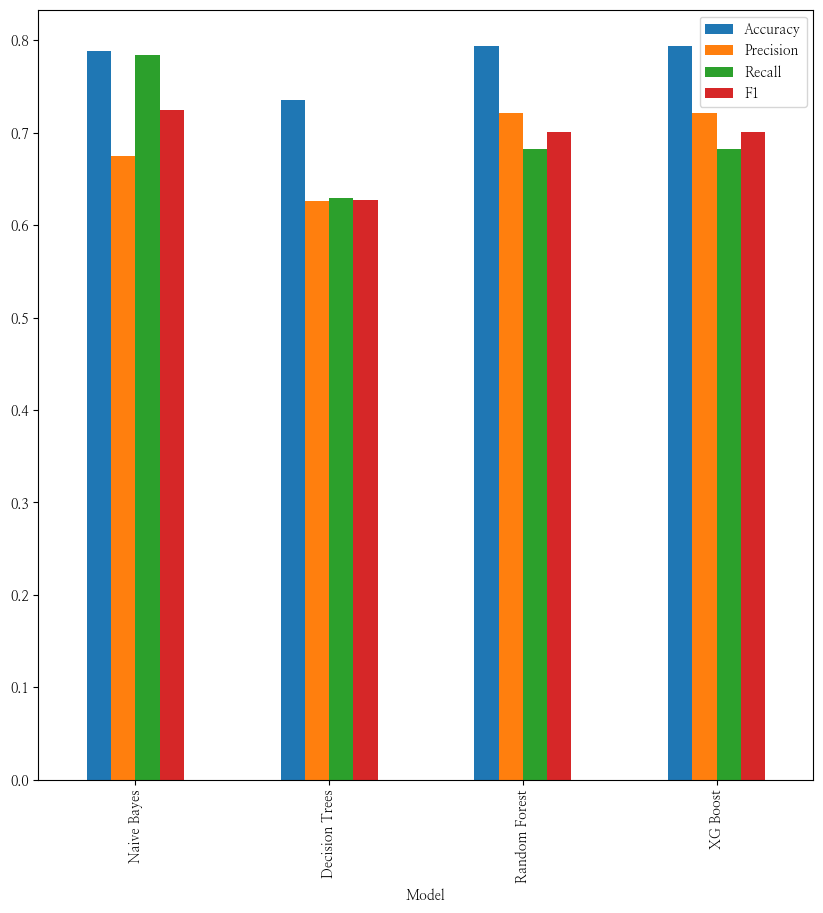

In [29]:
# 모형간 비교 및 평가 시각화
model_eval.plot(x='Model', y=['Accuracy','Precision','Recall','F1'], kind='bar', figsize=(10,10))
plt.show()

### 데이터 분석결과 해석 및 요약
#### - 비만 여부를 예측하는 모형을 구축하고자 하였다.
#### - 데이터 전처리를 통해 결측치를 제거하고, 명목형 데이터를 순서형 데이터로 변환하였다.
#### - Naive Bayes, Decision Trees, Random Forest, XG Boost 모형을 이용하여 비만 여부를 예측하였다.
#### - Naive Bayes가 대체로 좋은 성능을 보였다.